# Introduction to Word Embeddings

Open in [Google Colab](https://colab.research.google.com/github/febse/ta2025/blob/main/03-01-Word-Embeddings-Overview.ipynb)


Until now our approach to representing words has been treating them as discrete symbols. Each word was represented as a one-hot vector, i.e., a vector of length V (the size of the vocabulary) with a 1 in the position corresponding to the word and 0s elsewhere. 

For a document with the vocabulary consisting of the words "cat", "dog", "fish", the word "dog" would be represented as the vector [0, 1, 0], the word "cat" as [1, 0, 0], and the word "fish" as [0, 0, 1].

**This representation has several limitations:**


- The length of the vector is equal to the size of the vocabulary, which can be very large (tens or hundreds of thousands of words).
- This representation cannot capture any relationships between the words (all vectors are orthogonal to each other) and hence cannot capture semantic or syntactic similarities between words.

As a solution to the first problem we can use dense vector representations of words, i.e., vectors of much smaller size (e.g., 100 or 300 dimensions) where each dimension can take any real value. Such dense vector representations are called **word embeddings**. We actually already saw one method that in effect compressed the sparse one-hot vectors into dense vectors when we applied SVD to the term-document matrix in Latent Semantic Analysis (LSA).

However, these word embeddings are unlikely to capture semantic relationships between words if they are learned in isolation.

The word2vec model [@MIKOLOV2013EfficientEstimationWord] turned out to deliver impressive results by learning word embeddings based on the context in which words appear. There are two variants of the word2vec model: Continuous Bag of Words (CBOW) and Skip-gram.

The skip-gram model tries to predict the context words given a target word. The architecture of the skip-gram model is shown in the figure below.

For example in a sentence "The cat sits on the mat", if the target word is "sits", the context words could be "The", "cat", "on", "the", "mat". The model takes the one-hot vector of the target word as input, passes it through a hidden layer (which is essentially a weight matrix that transforms the one-hot vector into a dense vector), and then tries to predict the one-hot vectors of the context words.

![Skip-gram Model](./figures/skip-gram-architecture.webp)

To make sense of this architecture, let's consider some simpler models that will help us understand how the skip-gram model works.

## Linear Regression as a Neural Network



In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from IPython import display

In [2]:
n = 100
p = 1

np.random.seed(23)

X = np.random.randn(n, p)
e = np.random.randn(n)
beta = np.array([2])
y = 2 + X @ beta + e
y = (y - np.mean(y)) / np.std(y)

In [3]:
linreg = LinearRegression()
linreg.fit(X, y)

print("Intercept:", linreg.intercept_)
print("Coefficient:", linreg.coef_)


Intercept: -0.10302208818699159
Coefficient: [0.93074246]


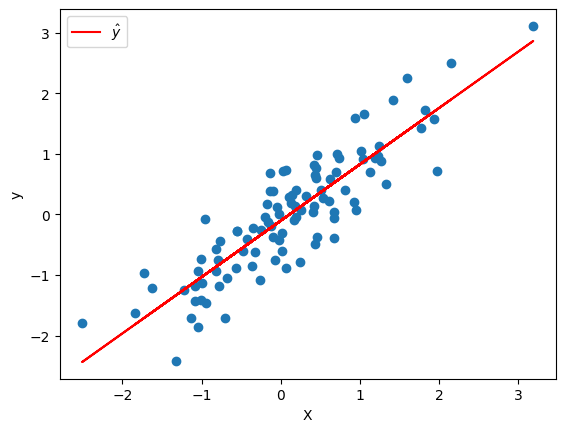

In [4]:
# Plot the predicted values

plt.scatter(X, y)
plt.plot(X, linreg.predict(X), color='red', label = r'$\hat{y}$')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

## Simple Linear Regression as a ANN

With one predictor variable the simple linear model predicts an outcome variable as a linear function of the predictor variable:

$$
\hat{y}_i = \hat{\beta}_0 + \beta_1 x_{i}
$$

Where the coefficients are chosen to minimize the mean squared error loss function.

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

A linear regression model is a special case of a neural network with no hidden layers, a linear activation function, and a mean squared error loss function. To be consistent with the literature on neural networks we will rename $\beta_1$ to $w$ (weights) and $\beta_0$ to $b$ (bias). The equation for the ANN model is
absolutely the same as for linear regression:

$$
\hat{y}_i = b + w x_{i}
$$

The usual visualization of this model is a single neuron with $p$ inputs and a single output. The neuron compute whe weighted sum of its inputs and passes this value to its output nodes. For linear regression the output of the is passed through an identity activation function $\mathbb{I}(z) = z$ (i.e. unchanged) to the output node which is the predicted value $\hat{y}_i$.

In the simplest case we have one input (feature) and one output (target variable):

$$
\hat{y}_i = \mathbb{I}(b + w x_i)
$$

![Linear Regression as a Neural Network](./figures/ann/Linear-Regression-Single-Input-Single-Output.png)

{{< video ./videos/SingleNeuronComputation.mp4 >}}

So if we know the values of the weight and the bias, we can compute the predicted value for any input by simply multiplying the input by the weight and adding the bias. How do we find sensible values for the weight and the bias?


## Gradient Descent for Simple Linear Regression

We can use gradient descent to find the optimal values of the weights and the bias that minimize the loss function. The loss function for linear regression is the mean squared error (MSE) which for a single observation (sample) is:

$$
L_i = (\text{actual} - \text{predicted})^2 = (y_i - \hat{y}_i)^2
$$

The gradient descent algorithm iteratively updates the weights and the bias in the direction of the negative gradient of the loss function with respect to the weights and the bias.

$$
\begin{align*}
w_1^{\text{new}} = w_1^{\text{old}} - \eta \frac{\partial L_i}{\partial w_1} \\
b^{\text{new}} = b^{\text{old}} - \eta \frac{\partial L_i}{\partial b}
\end{align*}
$$

where $\eta$ is the learning rate, a hyperparameter that controls the step size of the updates. To actually perform the updates, we need to compute the gradients of the loss function with respect to the weights and the bias. This is quite straightforward here:


$$
\begin{align*}
\frac{\partial L_i}{\partial w_1} & = \frac{\partial }{\partial w_1} (y_i - \hat{y}_i)^2 \\
                                  & = (y_i - \hat{y}_i) \frac{\partial }{\partial w_1} \hat{y}_i \\
                                  & = -2 (y_i - \hat{y}_i) x_{i}
\end{align*}
$$

$$
\begin{align*}
\frac{\partial L_i}{\partial b} & = \frac{\partial }{\partial b} (y_i - \hat{y}_i)^2 \\
                                  & = (y_i - \hat{y}_i) \frac{\partial }{\partial b} \hat{y}_i \\
                                  & = -2 (y_i - \hat{y}_i)
\end{align*}
$$

It is useful to also compute the update equations not just for a single observation, but for a subset (batch) of the observations.

The MSE loss for a batch of size m is:

$$
L = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2
$$

Exactly as before, we differentiate the loss with respect to the weight and the bias to get the update equations for the batch:

$$
\begin{align*}
\frac{\partial L}{\partial w} & = \frac{1}{m} \sum_{i=1}^{m} \frac{\partial }{\partial w} (y_i - \hat{y}_i)^2 \\
                                    & = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) \frac{\partial }{\partial w} \hat{y}_i \\
                                    & = -\frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) x_{i}                     
\end{align*}
$$               

It is also convenient to express these equations in vectorized form. It has the advantage that it maps nicely to matrix operations that we can express directly using `numpy`. Another advantage is that it generalizes easily to multiple input features and multiple output targets. Furthermore, vectorized operations are usually more computationally efficient. 

The sum involved in the gradient computation above is just the dot product of the column vectors of the errors $(y - \hat{y})$ and the inputs $x$:

$$
\begin{align*}
\frac{\partial L}{\partial w} & = -\frac{2}{m} (y - \hat{y})^T x \\
\frac{\partial L}{\partial b} & = -\frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)
\end{align*}
$$

or equivalently:

$$
\begin{align*}
\frac{\partial L}{\partial w} & = -\frac{2}{m} x^T (y - \hat{y}) \\
\frac{\partial L}{\partial b} & = -\frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)
\end{align*}
$$


Weight: 0.9307424583086401
Bias: -0.10302208834759351


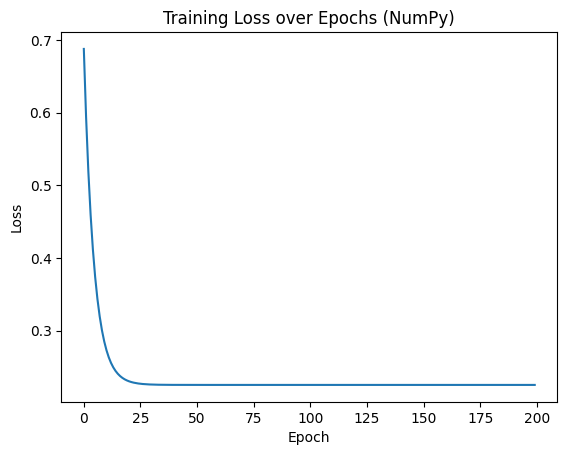

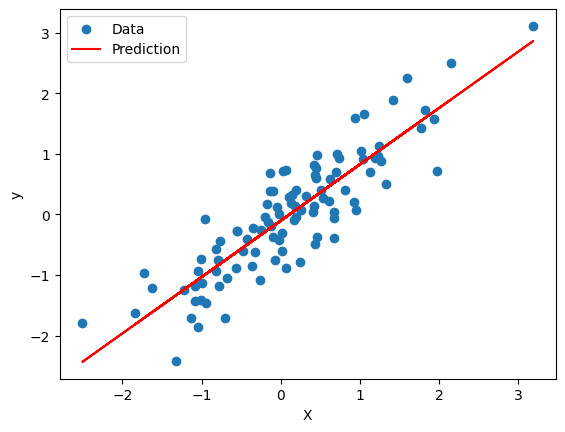

In [5]:
# Hyperparameters
epochs = 200
lr = 0.05

# First we initialize the parameters to 
# random values close to zero

w = np.random.randn(p).reshape(-1, p)
b = np.random.randn(1)

losses = []

# Training loop
for epoch in range(epochs):
    # Forward pass
    y_pred = X @ w + b
    
    # Compute loss (MSE)
    loss = np.mean((y.reshape(-1, 1) - y_pred) ** 2)
    losses.append(loss)
    
    # Backward pass (compute gradients)
    errors = y.reshape(-1, 1) - y_pred
    gradient_w = -2 * X.T @ errors / n
    gradient_b = -2 * errors.mean()
    
    # Update parameters
    w = w - lr * gradient_w
    b = b - lr * gradient_b

# Print final parameters
print("Weight:", w.item())
print("Bias:", b.item())

# Plot training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (NumPy)')
plt.show()

# Plot predictions
y_pred_final = X @ w + b

plt.scatter(X, y, label='Data')
plt.plot(X, y_pred_final, color='red', label='Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## A Neural Network and Function Approximation

Neural networks become more interesting when we add hidden layers and non-linear activation function.

{{< video ./videos/SingleInputHiddenLayer.mp4 >}}

For a network with one one input and two neurons in the hidden layer, one output and ReLU activation function, the equation for the output is:

https://www.desmos.com/calculator/jwruoptwuv


$$
\hat{y}_i = w_{o1} \cdot \text{ReLU}(h_{i1}) + w_{o2} \cdot \text{ReLU}(h_{i2}) + b_o
$$

The hidden layer neurons compute their activations as:

$$
\begin{align*}
h_{i1} & = w_{1} \cdot x_{i} + b_{1} \\
h_{i2} & = w_{2} \cdot x_{i} + b_{2}
\end{align*}
$$

Again, the MSE is the average squared difference between the actual and predicted values:

$$
MSE = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2
$$

So the final equation for the output is:

$$
\hat{y}_i = w_{o1} \cdot \underbrace{\text{ReLU}(w_{1} \cdot x_i + b_{1})}_{z_{i1}} + w_{o2} \cdot \underbrace{\text{ReLU}(w_{2} \cdot x_i + b_{2})}_{z_{i2}} + b_o
$$

https://www.desmos.com/calculator/gmsdth4fmf

## Tanh Activation

Replacing the ReLU activation function with $\tanh$ only changes the last equation:

$$
\begin{align*}
\hat{y} & = w_{o1} \tanh(h_{i1}) + w_{o2} \tanh(h_{i2}) + b_{o} \\
\end{align*}
$$

Let's derive the gradients with respect to the weights. The output layer is quite simple:

$$
\begin{align*}
\frac{\partial MSE}{\partial w_{o1}} & = \frac{\partial }{\partial w_{o1}} \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2 \\
                                  & = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) \frac{\partial }{\partial w_{o1}} \hat{y}_i \\
                                  & = -\frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) \tanh(h_{i1})
\end{align*}
$$

So this partial derivative is a scaled dot product of the errors and the activations of the first hidden neuron. Similarly for the second output weight:

$$
\begin{align*}
\frac{\partial MSE}{\partial w_{o2}} & = - \frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) \tanh(h_{i2})
\end{align*}
$$

We can pack these two equations into a whole gradient vector for the output weights:

$$
\frac{\partial MSE}{\partial w_{o}} = - \frac{2}{m} 
\begin{bmatrix}
\sum_{i=1}^{m} (y_i - \hat{y}_i) \tanh(h_{i1}) \\
\sum_{i=1}^{m} (y_i - \hat{y}_i) \tanh(h_{i2})
\end{bmatrix}
$$

or in vectorized form:

$$
\underbrace{\frac{\partial MSE}{\partial w_{o}}}_{2 \times 1} = - \frac{2}{m} 
\underbrace{Z^T}_{2 \times m} \underbrace{(y - \hat{y})}_{m \times 1}
$$

where Z is the matrix of hidden layer activations.

The gradients with respect to the hidden layer weights are a bit more involved because we need to apply the chain rule to account for the non-linear activation function. Let's derive the gradient with respect to the first hidden layer weight $w_1$. Before we do this, note that the derivative of the $\tanh$ function is:

$$
\frac{d}{d h} \tanh(h) = 1 - \tanh^2(h)
$$

$$
\begin{align*}
\frac{\partial MSE}{\partial w_{1}} & = \frac{\partial }{\partial w_{1}} \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2 \\
                                  & =   \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) \frac{\partial }{\partial w_{1}} \hat{y}_i \\
                                  & = -\frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) \frac{\partial }{\partial w_{1}} \left( w_{o1} \tanh(h_{i1}) + w_{o2} \tanh(h_{i2}) + b_{o} \right) \\
                                  & = -\frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) w_{o1} \frac{\partial }{\partial w_{1}} \tanh(h_{i1}) \\
                                    & = -\frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) w_{o1} \left( 1 - \tanh^2(h_{i1}) \right) \frac{\partial }{\partial w_{1}} h_{i1} \\
                                    & = -\frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) w_{o1} \left( 1 - \tanh^2(h_{i1}) \right) x_{i} \\
\end{align*}
$$

For the second hidden layer weight $w_2$ the derivation is similar:

$$
\begin{align*}
\frac{\partial MSE}{\partial w_{2}} & = -\frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) w_{o2} \left( 1 - \tanh^2(h_{i2}) \right) x_{i} \\
\end{align*}
$$


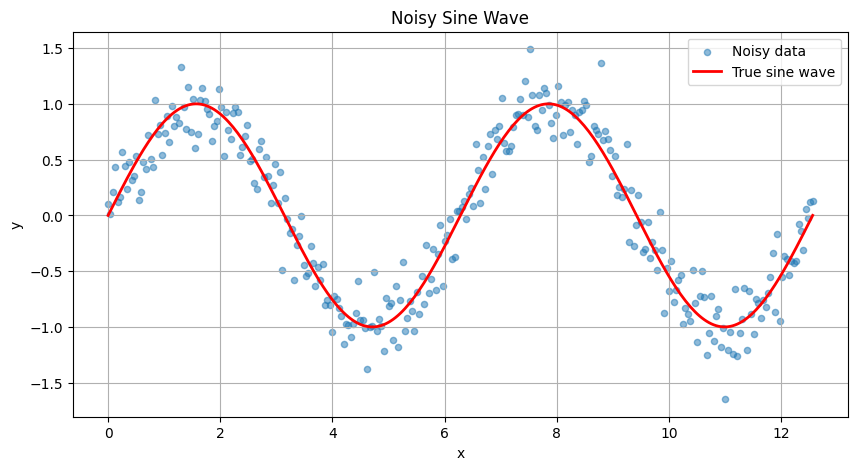

In [176]:
# Generate a noisy sine wave
np.random.seed(42)
x_sine = np.linspace(0, 4 * np.pi, 300)
y_sine = np.sin(x_sine) + np.random.randn(300) * 0.2

# Reshape and scale data for PyTorch
x_sine_scaled = (x_sine - np.mean(x_sine)) / np.std(x_sine)
y_sine_scaled = (y_sine - np.mean(y_sine)) / np.std(y_sine)

# Plot the noisy sine wave
plt.figure(figsize=(10, 5))
plt.scatter(x_sine, y_sine, alpha=0.5, s=20, label='Noisy data')
plt.plot(x_sine, np.sin(x_sine), 'r-', label='True sine wave', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy Sine Wave')
plt.legend()
plt.grid(True)
plt.show()


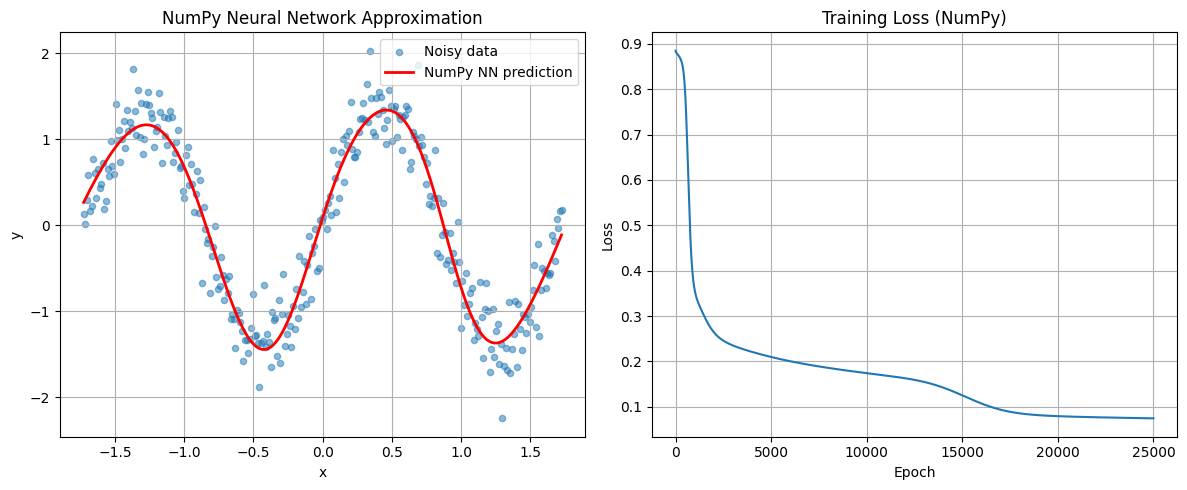

In [180]:
# Neural network regression using NumPy with learning rate=0.1 (10x higher than original)
np.random.seed(42)
torch.manual_seed(42)

hidden_size = 32

# Initialize with Xavier initialization
Wh = np.random.randn(1, hidden_size) * np.sqrt(2.0 / (1 + hidden_size))
bh = np.zeros((1, hidden_size))
Wo = np.random.randn(hidden_size, 1) * np.sqrt(2.0 / (hidden_size + 1))
bo = np.zeros((1, 1))

x_train_np = x_sine_scaled.reshape(-1, 1)
y_train_np = y_sine_scaled.reshape(-1, 1)

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1 - np.tanh(x) ** 2

# Training parameters - use lr=0.1 (10x higher than original 0.01)
epochs = 25_000
lr = 0.03
losses_np = []

# Training loop
for epoch in range(epochs):
    # Forward pass
    H = x_train_np @ Wh + bh
    Z = tanh(H)
    y_pred = Z @ Wo + bo
    
    # Compute loss (MSE)
    loss = np.mean((y_train_np - y_pred) ** 2)
    losses_np.append(loss)
    
    # Backward pass
    m = len(y_train_np)
    dLoss_dy = - 2 * (y_train_np - y_pred) / m
    
    # Output layer gradients
    dWo = Z.T @ dLoss_dy
    dbo = np.sum(dLoss_dy)
    
    # Hidden layer gradients
    dZ = dLoss_dy @ Wo.T
    dH = dZ * tanh_deriv(H)
    dWh = x_train_np.T @ dH
    dbh = np.sum(dH, axis=0, keepdims=True)
    
    # Update weights and biases
    Wo -= lr * dWo
    bo -= lr * dbo
    Wh -= lr * dWh
    bh -= lr * dbh

# Final predictions
H = x_train_np @ Wh + bh
Z = tanh(H)
y_pred_np_final = Z @ Wo + bo

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_train_np, y_train_np, alpha=0.5, s=20, label='Noisy data')
plt.plot(x_train_np, y_pred_np_final, 'r-', label='NumPy NN prediction', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('NumPy Neural Network Approximation')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(losses_np)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (NumPy)')
plt.grid(True)

plt.tight_layout()
plt.show()


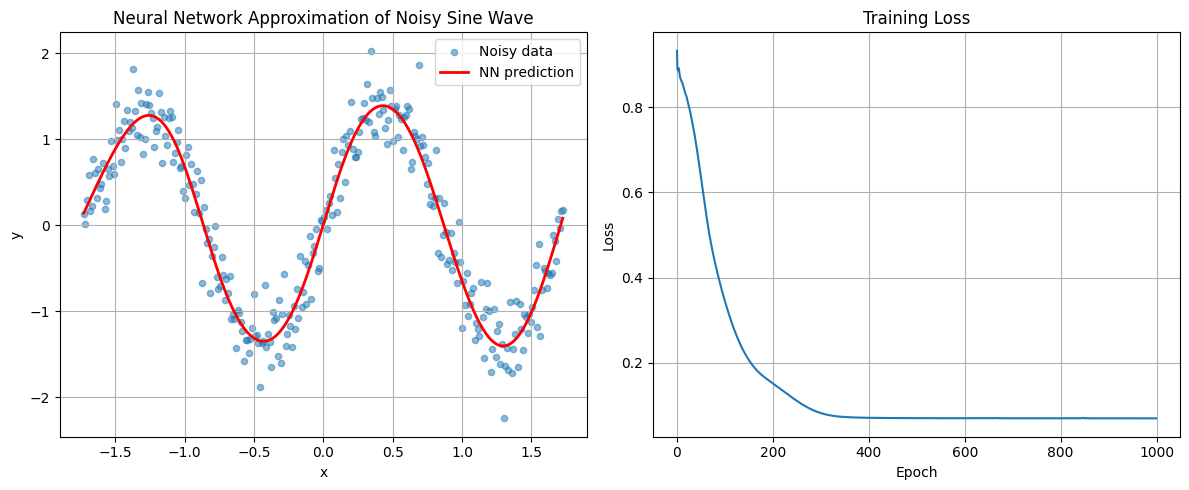

In [181]:
# Neural network regression using PyTorch
np.random.seed(42)
torch.manual_seed(42)

x_train = torch.from_numpy(x_sine_scaled.reshape(-1, 1)).float()
y_train = torch.from_numpy(y_sine_scaled.reshape(-1, 1)).float()

# Define the neural network
class SineNN(nn.Module):
    def __init__(self, hidden_size=12):
        super(SineNN, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
model = SineNN(hidden_size=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
losses = []

for epoch in range(epochs):
    # Forward pass
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Get predictions
with torch.no_grad():
    y_pred_final = model(x_train)

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train, alpha=0.5, s=20, label='Noisy data')
# plt.plot(x_train, np.sin(x_train), 'g-', label='True sine wave', linewidth=2)
plt.plot(x_train, y_pred_final.numpy(), 'r-', label='NN prediction', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network Approximation of Noisy Sine Wave')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.tight_layout()
plt.show()
